

## Table of contents
1. Load the raw data and remove unnessasary data
2. Feature engineering
3. Establish an XGB classification model based on feature engineering
4. Conclusion


In [69]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.stats import uniform


from sklearn.model_selection import cross_val_score

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import optuna

import warnings
warnings.filterwarnings("ignore")

#your info here
__author__ = "Hwayoung Jung"
__email__ = "whyyoungjung@gmail.com"


1. Load the raw data and remove unnessasary data based on EDA.

In [70]:

data = pd.read_csv("Bank Customer Churn Prediction.csv")

reduced_data = data.drop(['customer_id','country','tenure', 'credit_card', 'estimated_salary'],axis=1)

In [71]:
x_train = reduced_data.drop(['churn'], axis=1)
y_train = reduced_data['churn']

2. Feature engineering

In [72]:
# feature engineering function

def fe(data):
    age_groups = [0, 20, 30, 40, 50, 60, 100] # considering age distribution, clump ages between 0~ 20 and 60 and 100
    age_group_names = [1,2,3,4,5,6]

    data['age_group'] = pd.cut(data['age'], bins=age_groups, labels=age_group_names)
    data['age_group'] = data['age_group'].astype(int)

    data.loc[(data.age > 39) & (data.age < 60),'midage']=1
    data.loc[~((data.age > 39) & (data.age < 60)),'midage']=0
    return data


In [73]:
x_train = fe(x_train)

In [74]:
cat_columns = [c for c, t in zip(x_train.dtypes.index, x_train.dtypes) if (t == 'object' or t == 'category')] 
num_columns = [c for c in x_train.columns if c not in cat_columns]
print('Categorical Columns: \n{}\n\n Numeric Columns: \n{}\n'.format(cat_columns, num_columns))

Categorical Columns: 
['gender']

 Numeric Columns: 
['credit_score', 'age', 'balance', 'products_number', 'active_member', 'age_group', 'midage']



In [75]:
# pre-processing function


def preprocess(x_t_train, x_t_valid):
    x_t_train.reset_index(drop=True, inplace=True)
    x_t_valid.reset_index(drop=True, inplace=True)

    # feature scaling
    scaler = StandardScaler()
    x_t_train[num_columns] = scaler.fit_transform(x_t_train[num_columns])
    x_t_valid[num_columns] = scaler.transform(x_t_valid[num_columns])

    # feature encoding
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    x_t_train_cat = pd.DataFrame(
        data = ohe.fit_transform(x_t_train[cat_columns]),
        columns=ohe.get_feature_names_out())
    x_t_valid_cat =  pd.DataFrame(
        data = ohe.transform(x_t_valid[cat_columns]),
        columns=ohe.get_feature_names_out())


    x_t_train = pd.concat([x_t_train[num_columns], x_t_train_cat], axis=1)
    x_t_valid = pd.concat([x_t_valid[num_columns], x_t_valid_cat], axis=1)

    return x_t_train, x_t_valid

3. Establish an XGB classification model based on feature engineering

In [76]:
#https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning

# used auprc as an evaluation metric to tackle imbalanced data (https://towardsdatascience.com/imbalanced-data-stop-using-roc-auc-and-use-auprc-instead-46af4910a494)
from xgboost import XGBClassifier

def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }


# Fit the model
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    model = XGBClassifier(**params)
    model.fit(x_t_train, y_t_train, eval_metric='aucpr', eval_set=[(x_t_train, y_t_train), (x_t_valid, y_t_valid)],early_stopping_rounds=100, verbose = 0)

    # Make predictions (not actual value, predict "probability"!)
    y_pred_prob = model.predict_proba(x_t_valid)

    # Evaluate predictions
    auprc = sklearn.metrics.average_precision_score(y_t_valid, y_pred_prob[:,1])
    return auprc


In [77]:
from xgboost import XGBClassifier



x_t_train, x_t_valid, y_t_train, y_t_valid = train_test_split(x_train,y_train)
x_t_train, x_t_valid = preprocess(x_t_train, x_t_valid)


# Fit the model to find a best set of hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


In [78]:
# re-run model with the best set of parameters and calculate average MSE between cross validation sets
best_params = study.best_params



from sklearn.model_selection import KFold


kf = KFold(n_splits=5, random_state=42, shuffle=True)


val_scores = list()
#oof_pred = np.zeros((test.shape[0], ))

for i, (trn_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
    x_t_train, y_t_train = x_train.iloc[trn_idx, :], y_train[trn_idx]
    x_t_valid, y_t_valid = x_train.iloc[val_idx, :], y_train[val_idx]

    x_t_train, x_t_valid = preprocess(x_t_train, x_t_valid)

    model = XGBClassifier(**best_params)
    model.fit(x_t_train, y_t_train, eval_metric='aucpr', eval_set=[(x_t_train, y_t_train), (x_t_valid, y_t_valid)],early_stopping_rounds=100, verbose = 0)

    # Make predictions (not actual value, predict "probability"!)
    y_pred_prob = model.predict_proba(x_t_valid)

    # Evaluate predictions
    auprc = sklearn.metrics.average_precision_score(y_t_valid, y_pred_prob[:,1])
    val_scores.append(auprc)

print('Average AUPRC: {:.4f}'.format(np.mean(val_scores)))

Average AUPRC: 0.6822


In [79]:
from sklearn import metrics
# evaluation metric: auc
model = XGBClassifier(**best_params)
model.fit(x_t_train, y_t_train, eval_metric='auc', eval_set=[(x_t_train, y_t_train), (x_t_valid, y_t_valid)],early_stopping_rounds=100, verbose = 0)
# Make predictions (not actual value, predict "probability"!)
y_pred_prob = model.predict_proba(x_t_valid)
roc_auc = metrics.roc_auc_score(y_t_valid, y_pred_prob[:, 1])

In [80]:
roc_auc

0.8458874060438717

In [81]:
fpr, tpr, _ = metrics.roc_curve(y_t_valid,  y_pred_prob[:,1])


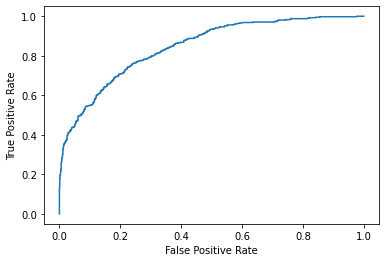

In [82]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

4. Conclusion

Using optuna model optimization with XGBoost Classifier, auc score of 0.85 was obtained, which indicates this model robustly predicts customer churn rate. Also, average AUCPR across K-folds was 0.682. AUCPR was used as an evaluation metric to handle imbalanced data.